In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import os
import numpy as np
import torch
import pickle

In [4]:
# cell containing the validation data, confusion intuition is telling me to check if the data is in form of CxDxHxW
val_objects_path = "/projects/katefgroup/shared_quant_models/val_extracted_object_tensors"
if not os.path.exists(val_objects_path):
    raise FileNotFoundError('specify the correct directory containing 3d validation object tensors')

unloaded_val_tensors = [os.path.join(val_objects_path, v) for v in os.listdir(val_objects_path)]

In [5]:
print(f'Number of validation tensors {len(unloaded_val_tensors)}')

Number of validation tensors 20


In [6]:
# cell containing train data
train_objects_path = "/projects/katefgroup/shared_quant_models/train_extracted_obj_tensors"
if not os.path.exists(train_objects_path):
    raise FileNotFoundError('specify the correct directory containing 3d train object tensors')

unloaded_train_tensors = [os.path.join(train_objects_path, t) for t in os.listdir(train_objects_path)]

In [7]:
print(f'Number of training tensors: {len(unloaded_train_tensors)}')

Number of training tensors: 113


### Strategy used to generate the nearest neighbour results
* For each validation object, compare it against all the training object using the dot product.
* Gather the top 10 results, along with the file path

In [8]:
# all the training tensors are loaded and kept in memory, this is not very efficient but good first step
train_object_tensors = [np.load(t_path, allow_pickle=True).item() for t_path in unloaded_train_tensors]

In [9]:
print(train_object_tensors[0].keys())

dict_keys(['tensor', 'ob_name', 'class_label', 'class_name'])


In [10]:
t_tensor2d = [t_dict['tensor'].squeeze(0).reshape(32, -1) for t_dict in train_object_tensors]
stacked_t_tensor2d = np.stack(t_tensor2d)
print(stacked_t_tensor2d.shape)

(113, 32, 32768)


In [11]:
# are the value normalized here
np.linalg.norm(t_tensor2d[0].T, axis=1)

array([0.48530304, 0.49344862, 0.49671987, ..., 0.57149315, 0.56073457,
       0.5420596 ], dtype=float32)

In [12]:
save_path = "/projects/katefgroup/shared_quant_models/results_3D_tensors_nearest_neighbours"
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [14]:
# now go through each validation object computing the distance to the every training object.
normalizer = np.prod([32]*6)
for i, v_path in enumerate(unloaded_val_tensors):
    v_dict = np.load(v_path, allow_pickle=True).item()
    
    # dont recompute things which are already computed
    save_dict_path = os.path.join(save_path, f'{v_dict["ob_name"]}.pkl')
    if os.path.exists(save_dict_path):
        print(f'running for {save_dict_path}')
        continue
    
    v_tensor = v_dict['tensor'].squeeze(0)
    v_tensor2d = v_tensor.reshape(32, -1).T
    query_object = 'cup' if v_dict['class_label'] == 0 else 'bottle'
    print(f'query object is {query_object}')
    # now I want to compare this tensor with each of the training set tensors
    affinity_values = [np.sum(np.dot(v_tensor2d, t_dict['tensor'].squeeze(0).reshape(32, -1))) / float(normalizer) for t_dict in train_object_tensors]
    # now find the top-10 closest elements from here
    assert len(affinity_values) == 113, "the calculation of the affinity values is wrong"
    affinity_values = np.asarray(affinity_values)
    top_10_closest = affinity_values.argsort()[-10:][::-1] # this gives me from max to min which I want #Ashwini is this right?
    # now that I have the top-10 closest elements lets check which class do they belong to
    key_labels = []
    object_ids = []
    for idx in top_10_closest:
        # get the t_dict corresponding to this index
        tr_dict = train_object_tensors[idx]
        key_labels.append('cup' if tr_dict['class_label'] == 0 else 'bottle')
        object_ids.append(tr_dict['ob_name'])
    print(key_labels)
    print(object_ids)
    
    # now save all of this information
    save_dict = dict()
    save_dict['key_labels'] = key_labels
    save_dict['object_ids'] = object_ids
    save_dict['true_label'] = query_object
    save_dict['true_object_id'] = v_dict['ob_name']
    print(save_dict)
    # now save this dict in memory
    save_dict_path = os.path.join(save_path, f'{v_dict["ob_name"]}.pkl')
    with open(save_dict_path, 'wb') as f:
        pickle.dump(save_dict, f)
    f.close()

running for /projects/katefgroup/shared_quant_models/results_3D_tensors_nearest_neighbours/8f2b8d281413a8bd5b326e4735ab9003.pkl
running for /projects/katefgroup/shared_quant_models/results_3D_tensors_nearest_neighbours/e593aa021f3fa324530647fc03dd20dc.pkl
running for /projects/katefgroup/shared_quant_models/results_3D_tensors_nearest_neighbours/d910d855fd179dc066c1a8ee69277898.pkl
running for /projects/katefgroup/shared_quant_models/results_3D_tensors_nearest_neighbours/b2498accc1c3fe732db3066d0100ee4.pkl
running for /projects/katefgroup/shared_quant_models/results_3D_tensors_nearest_neighbours/365f8a3cf397adf66e71bbd43f7f5d20.pkl
running for /projects/katefgroup/shared_quant_models/results_3D_tensors_nearest_neighbours/5c7c4cb503a757147dbda56eabff0c47.pkl
running for /projects/katefgroup/shared_quant_models/results_3D_tensors_nearest_neighbours/f853ac62bc288e48e56a63d21fb60ae9.pkl
running for /projects/katefgroup/shared_quant_models/results_3D_tensors_nearest_neighbours/a1bc36109cd382

### Plotting the query and the key objects

* For each of the query object, I have the ids of the top 10 key objects.
* Using these I can load the visual images, from data directory and display it

In [16]:
saved_results_directory = "/projects/katefgroup/shared_quant_models/results_3D_tensors_nearest_neighbours"
all_results = [os.path.join(saved_results_directory, fl) for fl in os.listdir(saved_results_directory)]
print(len(all_results))

20


In [56]:
# based on the true label and true object id I can get the true object and plot it
def plot_nearest_neighbours(a_results):
    with open(a_results, 'rb') as f:
        data = pickle.load(f)
    f.close()

    # now what is the base data path
    base_dataset_path = '/projects/katefgroup/shared_quant_models/data_with_bbox'
    data_dir = 'bottles_data' if data['true_label'] == 'bottle' else 'cups_data'
    full_data_path = os.path.join(base_dataset_path, data_dir)
    instance_data_path = os.path.join(full_data_path, f"visual_data_{data['true_object_id']}.npy")
    assert os.path.exists(instance_data_path)

    # now that I have the data path open it up, grab the ref cam image and plot it up
    visual_data = np.load(instance_data_path, allow_pickle=True).item()
    query_img = visual_data['rgb_camRs'][0]

    print(data['key_labels'])
    # now that I have the query image with me lets get all the key images
    key_images = []
    # for each key in key_labels first get whether it is bottles_data or the cups_data
    data_dirs = ['bottles_data' if d == 'bottle' else 'cups_data' for d in data['key_labels']]
    fd_path = [os.path.join(base_dataset_path, data_dir) for data_dir in data_dirs]
    instance_ = [os.path.join(fd, f'visual_data_{inst}.npy') for fd, inst in zip(fd_path, data['object_ids'])]
    assert all([os.path.exists(inst) for inst in instance_])

    # load all of the instance and add the image to key images
    for inst in instance_:
        vis_key_data = np.load(inst, allow_pickle=True).item()
        key_images.append(vis_key_data['rgb_camRs'][0])

    # plot all the query image along with all the key images
    fig_size = 2 * np.asarray([11, 2])
    fig, axes = plt.subplots(1, 11, figsize=fig_size, sharex=True, sharey=True)
    axes[0].imshow(query_img)
    for j in range(1,11):
        axes[j].imshow(key_images[j-1])

['cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup']
['bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle']
['bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle']
['bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle']
['cup', 'bottle', 'cup', 'cup', 'bottle', 'bottle', 'cup', 'cup', 'cup', 'cup']
['cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup']
['bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle']
['bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle']
['bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle']
['cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup', 'cup']
['bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle']


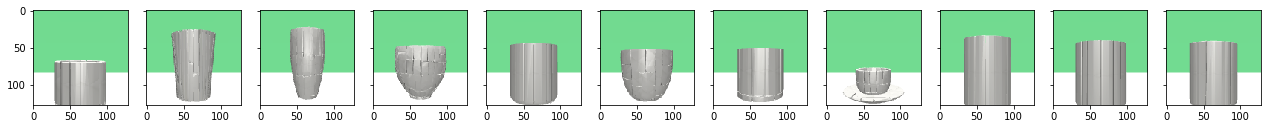

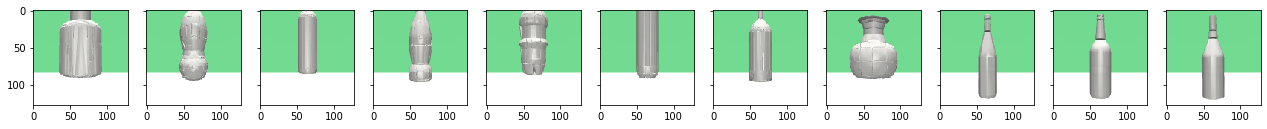

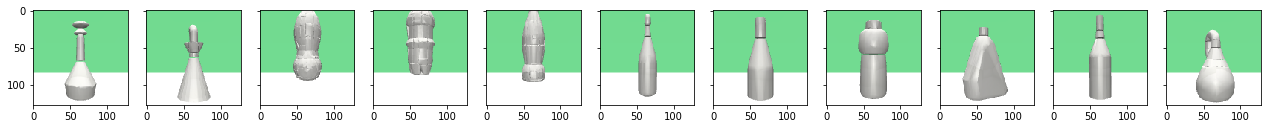

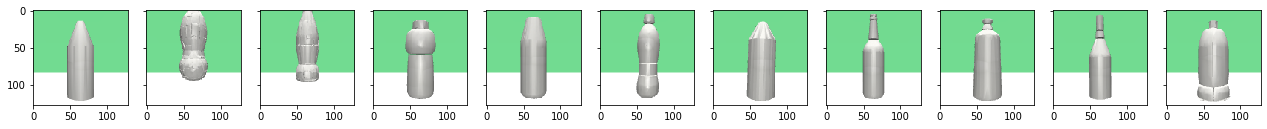

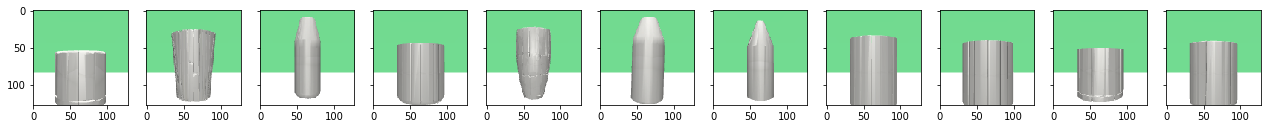

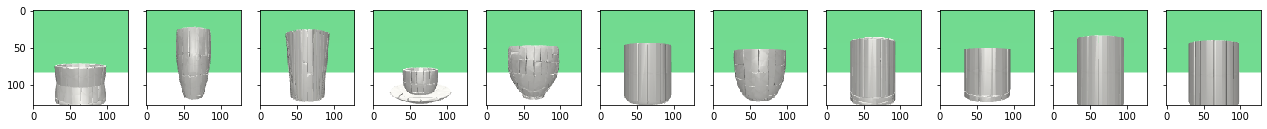

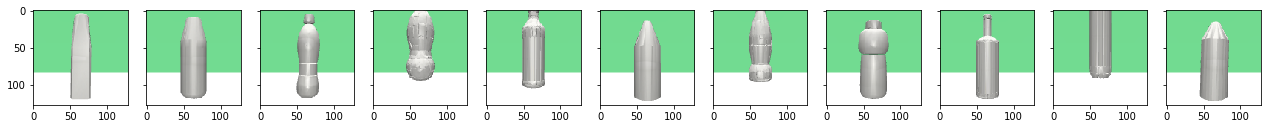

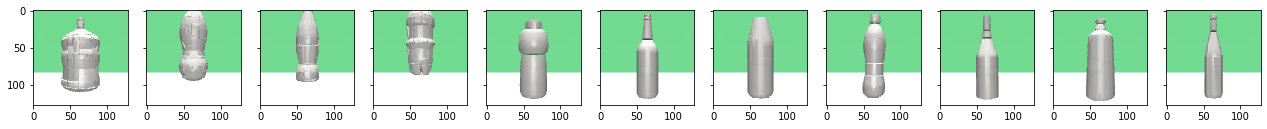

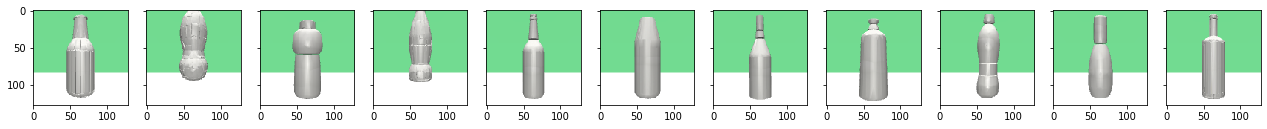

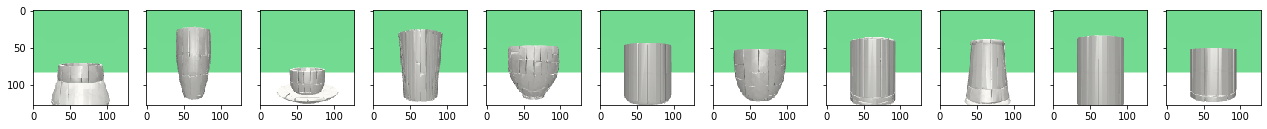

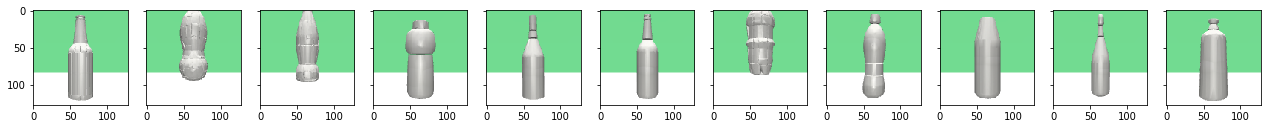

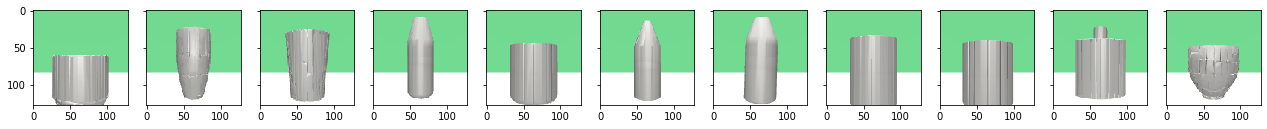

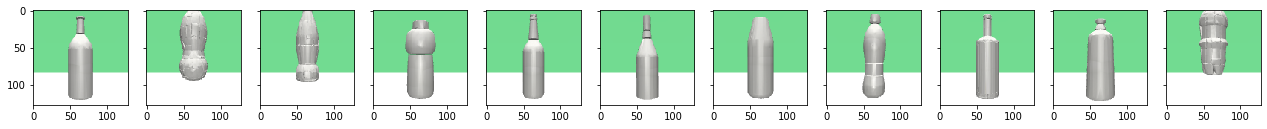

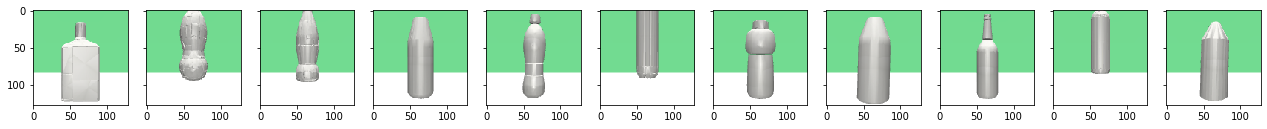

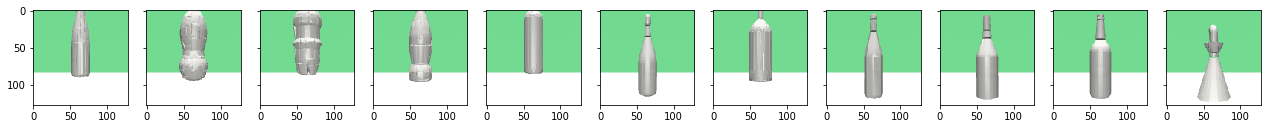

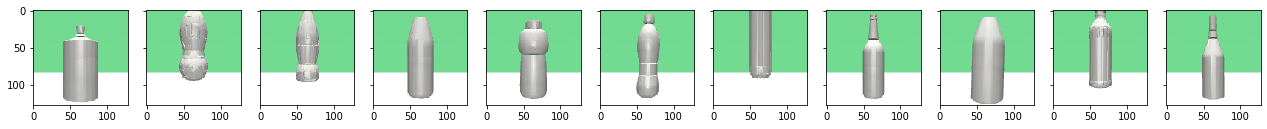

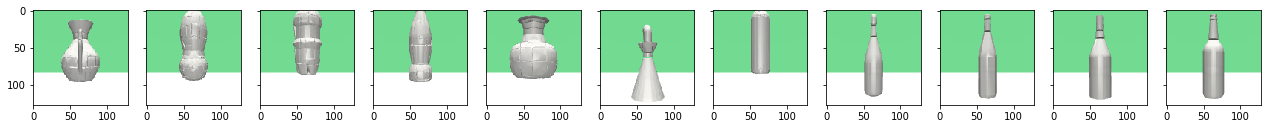

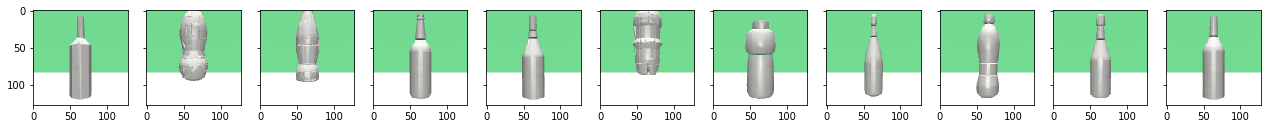

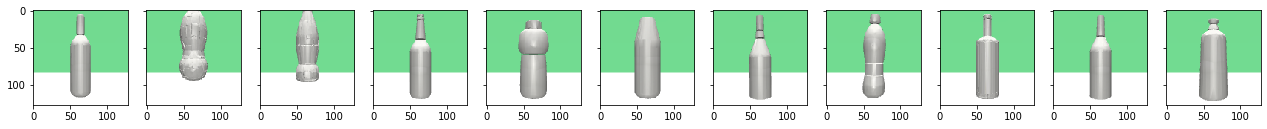

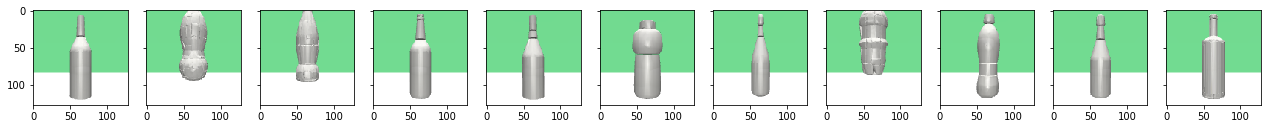

In [57]:
for a_result in all_results:
    plot_nearest_neighbours(a_result)